## Подготовка фотографий к обучению

In [ ]:
import os
import shutil
from tqdm.auto import tqdm

# Исходная директория, где находятся папки с изображениями
src_dir = '/home/jupyter/datasphere/project/data/SoccerNetGS/gamestate-2024/challenge'

# Целевая директория, куда будут скопированы все изображения
dst_dir = '/home/jupyter/datasphere/train_football'

# Убедимся, что целевая директория существует, если нет - создаем её
os.makedirs(dst_dir, exist_ok=True)

# Расширения файлов изображений, которые нужно копировать
image_extensions = ['.jpg', '.jpeg', '.png']

# Проход по всем папкам и подпапкам исходной директории
for root, dirs, files in tqdm(os.walk(src_dir)):
    for file in files:
        # Проверяем, является ли файл изображением по его расширению
        if any(file.lower().endswith(ext) for ext in image_extensions):
            # Полный путь к исходному файлу
            src_file = os.path.join(root, file)
            
            # Путь к целевому файлу (копируем в целевую директорию)
            dst_file = os.path.join(dst_dir, file)
            
            # Копирование файла
            shutil.copy2(src_file, dst_file)

print('Все изображения успешно скопированы.')


In [ ]:
import os
import shutil
from tqdm.auto import tqdm

# Пути к папкам
source_dir = '/home/jupyter/datasphere/project/data/SoccerNetGS/gamestate-2024/train'
train_dir = '/home/jupyter/datasphere/BigData/images/train'
val_dir = '/home/jupyter/datasphere/BigData/images/val'

# Получаем список всех папок SNGS в source_dir
folders = sorted([os.path.join(source_dir, d) for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d)) and 'SNGS' in d])

# Проход по всем папкам SNGS
for i, folder in (enumerate(tqdm(folders))):
    img1_dir = os.path.join(folder, 'img1')
    
    # Проверяем, существует ли папка img1 внутри папки SNGS
    if os.path.exists(img1_dir):
        # Каждая пятая папка перемещается в val
        if (i + 1) % 5 == 0:
            target_dir = os.path.join(val_dir, os.path.basename(folder))
        else:
            # Остальные папки перемещаем в train
            target_dir = os.path.join(train_dir, os.path.basename(folder))
        
        # Копирование папки
        shutil.copytree(img1_dir, target_dir)
        


## Для каждой фотографии создаем текстовый файл, каждую пятую папку копируем в валидацию.

In [ ]:
import os
import shutil
import json
from tqdm.auto import tqdm

# Пути к папкам
source_dir = '/home/jupyter/datasphere/project/data/SoccerNetGS/gamestate-2024/valid'
train_dir = '/home/jupyter/datasphere/BigData/images/train'
val_dir = '/home/jupyter/datasphere/BigData/images/val'
train_labels_dir = '/home/jupyter/datasphere/BigData/labels/train'
val_labels_dir = '/home/jupyter/datasphere/BigData/labels/val'

# Создаем директории для train и val, если они не существуют
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Получаем список всех папок SNGS в source_dir
folders = sorted([os.path.join(source_dir, d) for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d)) and 'SNGS' in d])

# Переменная для отслеживания последовательных имен
image_counter = 42751

# Функция для игнорирования скрытых файлов и папок
def is_hidden_file_or_dir(filename):
    return filename.startswith('.')

# Проход по всем папкам SNGS
for i, folder in enumerate(tqdm(folders)):
    img1_dir = os.path.join(folder, 'img1')
    json_file = os.path.join(folder, 'Labels-GameState.json')  # Предполагаем, что в каждой папке есть JSON файл
    
    # Определяем целевые директории для изображений и аннотаций
    if (i + 1) % 5 == 0:
        target_dir = val_dir
        target_labels_dir = val_labels_dir
    else:
        target_dir = train_dir
        target_labels_dir = train_labels_dir

    # Читаем JSON файл один раз для всех изображений в текущей папке
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # Поиск ID для класса мяча
        ball_class_id = None
        for category in data['categories']:
            if category['name'].lower() == 'ball':
                ball_class_id = category['id']
                break

        if ball_class_id is None:
            raise ValueError("Не удалось найти класс 'ball' в аннотациях.")
    
        # Создаем словарь для быстрого поиска аннотаций по image_id
        annotations_by_image = {}
        for ann in data['annotations']:
            if ann['category_id'] == ball_class_id:
                if ann['image_id'] not in annotations_by_image:
                    annotations_by_image[ann['image_id']] = ann

        # Работа с изображениями
        if os.path.exists(img1_dir):
            for img_name in sorted(os.listdir(img1_dir)):
                # Пропускаем скрытые файлы и папки, включая .ipynb_checkpoints
                if is_hidden_file_or_dir(img_name):
                    continue
                
                img_path = os.path.join(img1_dir, img_name)
                new_img_name = f"{image_counter:06}.jpg"
                new_img_path = os.path.join(target_dir, new_img_name)
                shutil.copy(img_path, new_img_path)
                
                # Найти соответствующее изображение в аннотациях
                image_info = next((img for img in data['images'] if img['file_name'] == img_name), None)
                if image_info:
                    image_id = image_info['image_id']
                    img_width = image_info['width']
                    img_height = image_info['height']

                    # Поиск аннотации для мяча
                    annotation = annotations_by_image.get(image_id, None)
                    
                    if annotation:
                        # Координаты bounding box
                        bbox = annotation['bbox_image']
                        x, y, width, height = bbox['x'], bbox['y'], bbox['w'], bbox['h']

                        # Нормализация координат для YOLO
                        x_center = (x + width / 2) / img_width
                        y_center = (y + height / 2) / img_height
                        width_norm = width / img_width
                        height_norm = height / img_height

                        # Создание аннотации в формате YOLO
                        annotation_file = os.path.join(target_labels_dir, new_img_name.replace('.jpg', '.txt'))
                        with open(annotation_file, 'w') as af:
                            af.write(f"0 {x_center} {y_center} {width_norm} {height_norm}\n")
                
                image_counter += 1


## Первый эксперимент с использованием yolo11-nano

In [ ]:
from ultralytics import YOLO

# Загрузка модели
model = YOLO('yolo11n.pt')  # Используем наиболее легкую модель для начала

# Обучение модели
model.train(data='/home/jupyter/datasphere/BigData/data.yaml', epochs=3, imgsz=640)


## Второй эксперимент (yolov11-medium, добавил регуляризацию, размер батча - 16)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11m.pt') 

model.train(
    data='/home/jupyter/datasphere/BigData/data.yaml', 
    epochs=4,              # Количество эпох
    imgsz=640,              # Размер изображений
    batch=16,               # Размер батча
    optimizer='AdamW',      # Оптимизатор
    weight_decay=0.0005  # Регуляризация
)

# Отчет по качеству модели:

## Первая модель (yolo nano)

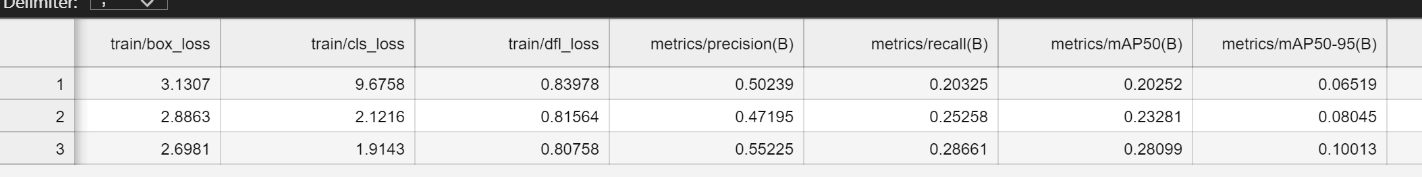

В целом, можем наблюдать, что с каждой эпохой все метрики демонстрируют неплохой рост. Потери на валидационном наборе данных также снижаются, что позволяет нам говорить о том, что модель не переобучается и способна обобщать данные. При этом мы наблюдаем рост metrics/precision(B), metrics/recall(B) и metrics/mAP50(B), что свидетельствует о повышении качества детекции объектов. Например, metrics/mAP50(B) увеличился с 0.20252 до 0.28099, что является значительным улучшением. В силу того, что фотографий было много, аугментации не применял. Обучение шло относительно долго, поэтому было принято остановиться на 3-х эпохах. Считаю, что продолжив обучение, метрики продолжили бы расти, точность стала бы выше.

## Вторая модель (yolo medium)

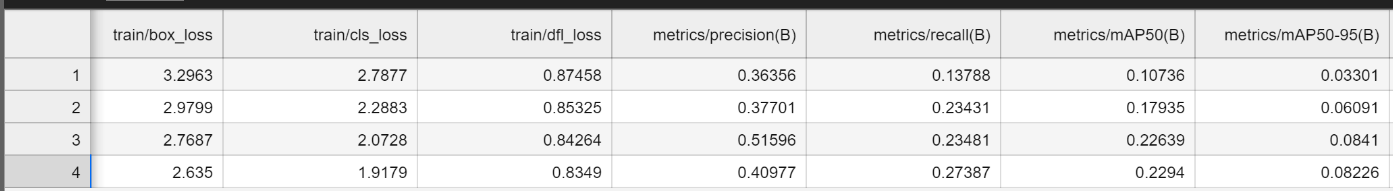

train/box_loss, train/cls_loss и train/dfl_loss имеют тенденцию к снижению с каждой эпохой, что указывает на улучшение обучения модели. Например, train/box_loss снизился с 3.2963 до 2.635, что свидетельствует о более точном определении границ объектов.
Несмотря на снижение потерь, метрики качества, такие как metrics/mAP50(B), остаются ниже, чем в предыдущем эксперименте, где использовалась более простая модель YOLO. На первой эпохе значение metrics/mAP50(B) составляет 0.10736, что ниже, чем даже на первом этапе предыдущего обучения (0.20252). Скорее всего, это связано с тем, что yolo medium более сложная модель и требует больше эпох для качественного обучения. В целом рост метрик заметен, поэтому продолжить обучение имеет смысл.


## Оценка работы модели на наборе challenge (оценка проводилась на основе фотографий в следующей папке: '/home/jupyter/datasphere/project/data/SoccerNetGS/gamestate-2024/challenge/SNGS-002/img1'

In [ ]:
import cv2
import os
from ultralytics import YOLO

# Загрузка обученной модели
model = YOLO('/home/jupyter/datasphere/runs/detect/train21/weights/best.pt')  # Укажите путь к весам модели

# Путь к тестовым изображениям
test_images_path = '/home/jupyter/datasphere/project/data/SoccerNetGS/gamestate-2024/challenge/SNGS-002/img1'  # Укажите директорию с тестовыми изображениями

# Получаем список всех изображений в папке
image_files = [os.path.join(test_images_path, img) for img in os.listdir(test_images_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Проходим по всем изображениям
for img_path in image_files:
    # Загружаем изображение
    img = cv2.imread(img_path)

    # Применяем модель YOLO для детекции
    results = model(img)
    
    # Извлекаем координаты детекций
    for result in results:
        boxes = result.boxes.xyxy  # Достаем координаты боксов (x_min, y_min, x_max, y_max)
        for box in boxes:
            # Центр бокса мяча
            x_center = int((box[0] + box[2]) / 2)
            y_center = int((box[1] + box[3]) / 2)

            # Координаты для начала и конца стрелки
            start_point = (x_center, y_center + 20)  # Точка чуть ниже центра мяча
            end_point = (x_center, y_center)  # Центр мяча

            # Рисуем зеленую стрелку, указывающую на мяч
            cv2.arrowedLine(img, start_point, end_point, (0, 255, 0), 3, tipLength=0.5)

    # Генерируем путь для сохранения результатов
    output_img_path = os.path.join(test_images_path, 'results', os.path.basename(img_path))
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    # Сохраняем изображение с нарисованной стрелкой
    cv2.imwrite(output_img_path, img)

print(f'Обработанные изображения сохранены в папке: {os.path.join(test_images_path, "results")}')


# Детекция мяча + трекинг + интерполяция (Исходный фрагмент взял из интернета, его прикреплю в письме)

In [ ]:
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO

# Загрузка обученной модели
model = YOLO('/home/jupyter/datasphere/runs/detect/train21/weights/best.pt')  # Путь к лучшим весам

# Путь к видео
video_path = '/home/jupyter/datasphere/New Project — сделано в Clipchamp.mp4'
output_video_path = '/home/jupyter/datasphere/runs/detect/train4/output_with_tracking.mp4'  # Указываем путь с расширением .mp4

# Открываем видео
cap = cv2.VideoCapture(video_path)

# Проверяем, открылось ли видео
if not cap.isOpened():
    print("Ошибка: не удалось открыть видео.")
    exit()

# Получаем параметры видео
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Подготовка для записи видео с результатами
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Используем кодек mp4v для записи в формате mp4
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Координаты для визуализации трека
track_points = []

# Порог для выбросов (размер, на сколько текущая точка может отличаться от предыдущей)
threshold_distance = 250

# Функция для проверки выбросов
def is_outlier(new_point, last_point, threshold=threshold_distance):
    if last_point is None:
        return False
    dist = np.sqrt((new_point[0] - last_point[0]) ** 2 + (new_point[1] - last_point[1]) ** 2)
    return dist > threshold

# Функция для интерполяции пропущенных значений
def interpolate_track_points(points):
    # Удаляем точки с None
    valid_points = [(x, y) if x is not None and y is not None else (np.nan, np.nan) for x, y in points]
    
    # Преобразуем список в DataFrame для интерполяции
    df_points = pd.DataFrame(valid_points, columns=['x', 'y'])
    df_points = df_points.interpolate()  # Интерполируем пропущенные значения
    df_points = df_points.bfill()  # Заполняем значения до интерполяции, если начало данных отсутствует
    df_points = df_points.ffill()  # Заполняем значения после интерполяции, если есть пропуски в конце
    return df_points.to_numpy().tolist()

# Чтение кадров и детекция мяча
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Применяем модель YOLO для детекции мяча на каждом кадре
    results = model(frame)
    
    # Извлекаем координаты детекций
    for result in results:
        boxes = result.boxes.xyxy  # Достаем координаты боксов (x_min, y_min, x_max, y_max)
        for box in boxes:
            # Центр бокса мяча
            x_center = int((box[0] + box[2]) / 2)
            y_center = int((box[1] + box[3]) / 2)

            # Проверяем, если координаты сильно отличаются от предыдущих, то это выброс
            if track_points and is_outlier((x_center, y_center), track_points[-1]):
                print("Обнаружен выброс, интерполяция...")
                track_points.append((np.nan, np.nan))  # Добавляем NaN для последующей интерполяции
            else:
                # Добавляем в список точек для трека
                track_points.append((x_center, y_center))

            # Рисуем детекцию на кадре
            cv2.circle(frame, (x_center, y_center), 5, (0, 255, 0), -1)

            # Рисуем треугольник над мячом
            triangle_points = np.array([[x_center, y_center - 10], 
                                         [x_center - 5, y_center - 15], 
                                         [x_center + 5, y_center - 15]], np.int32)
            cv2.fillPoly(frame, [triangle_points], (0, 255, 0))  # Зеленый треугольник

    # Интерполируем координаты для корректного трека
    track_points = interpolate_track_points(track_points)

    # Рисуем градиентный трек на каждом кадре
    for i in range(1, len(track_points)):
        if np.isnan(track_points[i - 1][0]) or np.isnan(track_points[i][0]):
            continue
        
        # Генерация цвета на основе индекса точки
        color = (255, int(255 * (i / len(track_points))), 0)  # Плавный переход от красного к зеленому
        cv2.line(frame, tuple(map(int, track_points[i - 1])), tuple(map(int, track_points[i])), color, 2)

    # Записываем обработанный кадр в видео
    out.write(frame)

# Завершаем работу с видео
cap.release()
out.release()

print(f'Видео с трекингом и интерполяцией сохранено по адресу: {output_video_path}')


# Отчет по траектории движения мяча

Алгоритм трекинга мяча с использованием модели YOLO реализует подход к детекции и визуализации движения объекта на видео. Он включает в себя загрузку предварительно обученной модели YOLO и обработку видеофайла, где каждый кадр анализируется для нахождения мяча. Координаты детекций используются для отрисовки на видео треугольников, обозначающих положение мяча. Для обработки выбросов, вызванных резкими изменениями в позициях, применяется интерполяция пропущенных значений, что позволяет создать плавный трек движения. Для улучшения качества отслеживания мяча, можно попробовать изменить порог threshold (чтобы отрисовка была в пределах предыдущего положения мяча). Также можно попробовать другой способ интерполяции, чтобы сглаживание выбросов было более плавным.